In [1]:
# Magic functions -- Run Once
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
# Set default figure size
plt.rcParams["figure.figsize"] = (12, 5)

import warnings
# Ignore all warnings (This might not be a good idea)
warnings.filterwarnings('ignore')

from utils.notebook.generic import full_width_notebook
# Set notebook to 100% width
full_width_notebook()

# Move up one folder to reach the repo root
%cd ..

/home/j3romee/dev/maitrise/film-aqa


In [2]:
from main import parse_args_string, prepare_for_task
from utils.notebook.generic import notebook_input_prompt
from utils.visualization import get_tagged_scene, get_tagged_scene_table_legend
from runner import custom_question_inference

data_root_path = "data"
config_path = "config/film_reduced.json"
config_path = "output/training/v3_fixed_5k_40_inst_1024_win_50_overlap_hpc-puget-necotis/2019-11-16_12h49/config_conv_input.json"
random_seed = 667
image_size = 224
set_type = 'train'

data_version_name = "v3_fixed_0.50k_40_inst_1024_win_50_overlap"

# Model weight restore
model_restore_folder = "output/training/v3_fixed_5k_40_inst_1024_win_50_overlap_hpc-puget-necotis/2019-11-16_12h49"
model_weight_path = f"{model_restore_folder}/best/model.pt.tar"
model_dict_file_path = f"{model_restore_folder}/dict.json"

# FIXME : Clear mean & std might be wrong (It is written in the config file)

arguments = (
    f"--notebook_model_inference --version_name {data_version_name} --config_path {config_path} --batch_size 4 "
    f"--random_seed {random_seed} --dict_folder questions --resize_to_square_images --pad_to_largest_image "
    f"--raw_img_resize_val {image_size} --raw_img_resize_based_on_width --no_feature_extractor --normalize_with_clear_stats "
    f"--film_model_weight_path {model_weight_path} --dict_file_path {model_dict_file_path}"
)
            
args = parse_args_string(arguments)
task_and_more, dataloaders, model_and_more = prepare_for_task(args)
print("Preparation done")
task, args, flags, paths, device = task_and_more
film_model_config, film_model, optimizer, loss_criterion, scheduler, tensorboard = model_and_more
datasets = {set_type:dloader.dataset for set_type, dloader in dataloaders.items()}



Task 'Notebook Model Inference' for version 'v3_fixed_0.50k_40_inst_1024_win_50_overlap'

Using device 'cpu'
Creating Datasets
Creating Dataloaders
Creating model
Restoring model weights from 'output/training/v3_fixed_5k_40_inst_1024_win_50_overlap_hpc-puget-necotis/2019-11-16_12h49/best/model.pt.tar'
Model ready to run

-------------------------------------------------------------------------------------------------------
        Layer (type)                         Input Shape                   Output Shape         Param #
         Embedding-1                            [-1, 22]                   [-1, 22, 64]           5,632
           Dropout-2                        [-1, 22, 64]                   [-1, 22, 64]               0
               GRU-3                        [-1, 22, 64]  [[-1, 22, 128], [-1, 2, 128]]               0
           Dropout-4                           [-1, 128]                      [-1, 128]               0
         Conv2d_tf-5                   [-1, 5, 224, 

In [3]:
# Retrieve random game

random_game = datasets[set_type].get_random_game(return_game=True)
scene_id = random_game['scene_id']

<IPython.core.display.Javascript object>


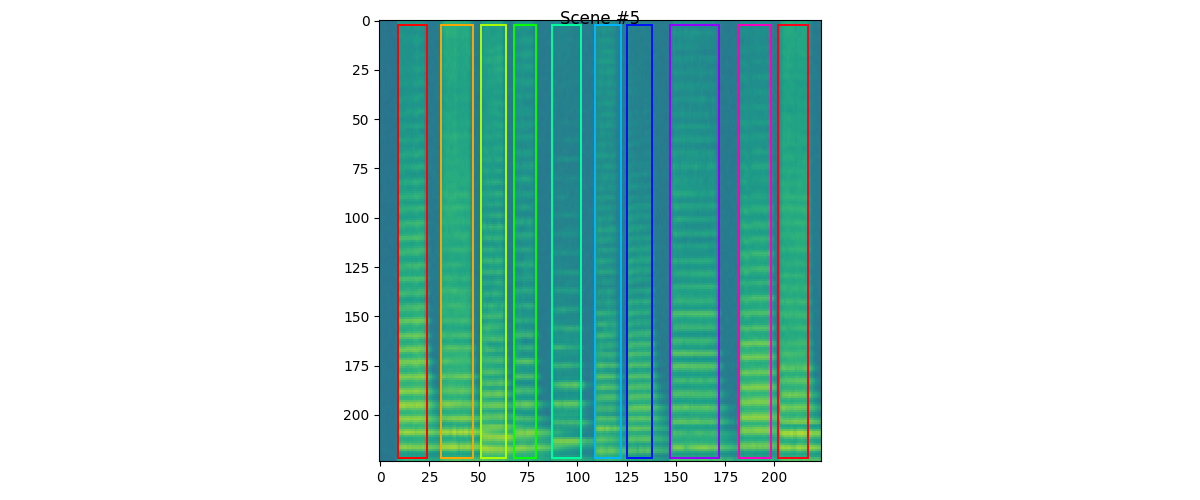

,0,1,2,3,4,5,6,7,8,9
instrument,trumpet,flute,cello,cello,clarinet,cello,trumpet,violin,trumpet,flute
loudness,loud,loud,loud,quiet,quiet,quiet,quiet,quiet,loud,loud
brightness,bright,None,dark,bright,bright,bright,None,bright,dark,dark
note,F,F,C#,F,A#,C,C,E,F#,E
id,20,1,39,3,12,45,29,49,18,36


[Brightness]Question (200):                       Answer for proposed question: dark


[Position]Question (201):                         Answer for proposed question: fifth


[Boolean]Question (203):                          Answer for proposed question: yes


[Count]Question (204):                            Answer for proposed question: 4


[Note]Question (206):                             Answer for proposed question: e


[Position_global]Question (208):                  Answer for proposed question: beginning of the scene


[Instrument]Question (217):                       Answer for proposed question: violin



No question of family loudness for this scene



In [4]:
# Show scene & Example questions
from utils.notebook.inference import show_game_notebook_input

custom_question, custom_questions = show_game_notebook_input(dataloaders[set_type], random_game, film_model_config['preprocessing']['clear_stats'])

Question : what is the brightness of the trumpet sound playing after the violin that play the e note <unk>
Correct Answer
  Guess 0:                      Dark ---- 0.9915403723716736
  Guess 1:                    Bright ---- 0.008459614589810371
  Guess 2:                         B ---- 1.592523002358348e-09
  Guess 3:                     Cello ---- 8.533852097203365e-11
  Guess 4:                     Quiet ---- 7.750416280982719e-11


### GradCam visualization Guess #1  ---- [dark]

<IPython.core.display.Javascript object>


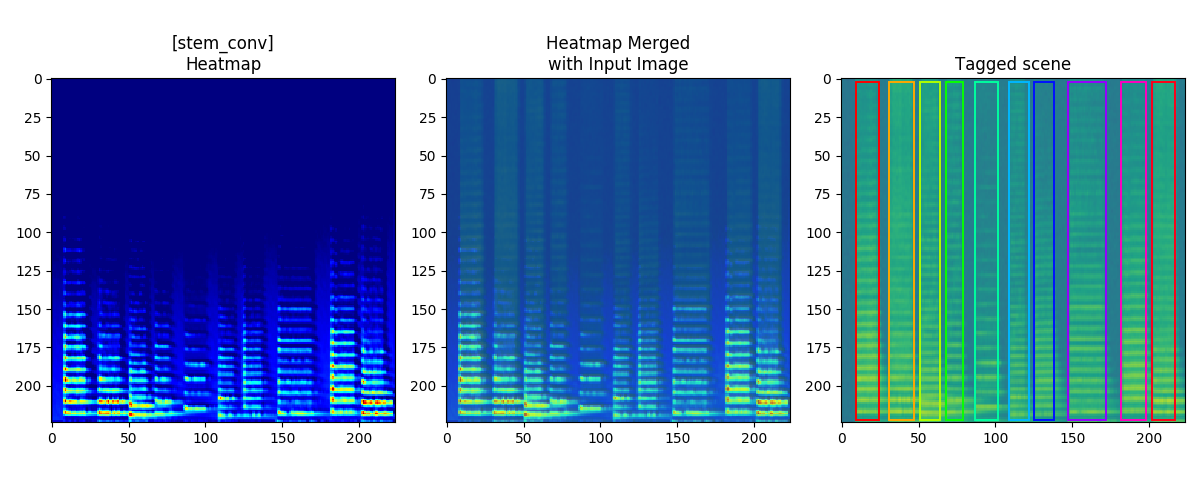

<IPython.core.display.Javascript object>


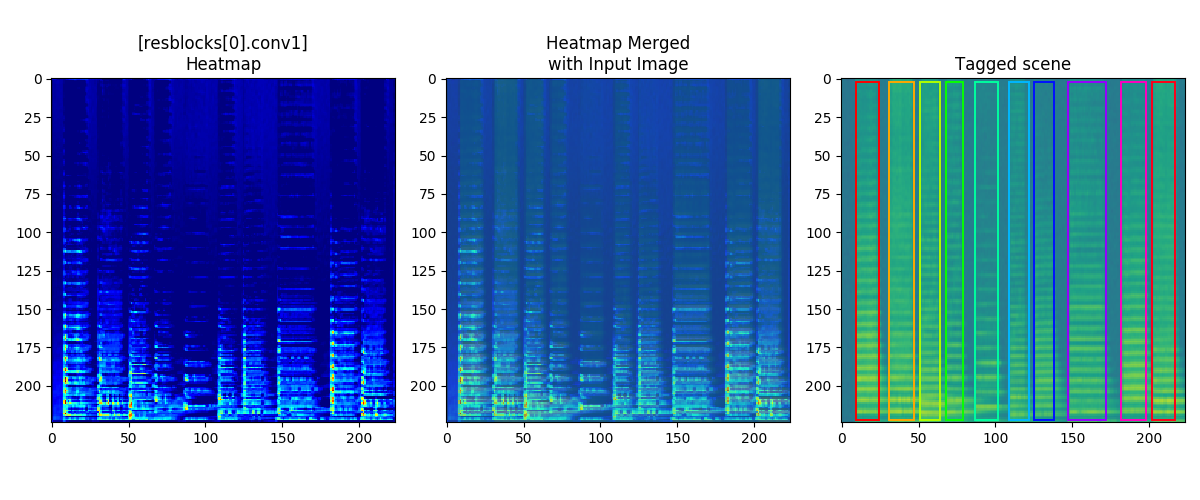

<IPython.core.display.Javascript object>


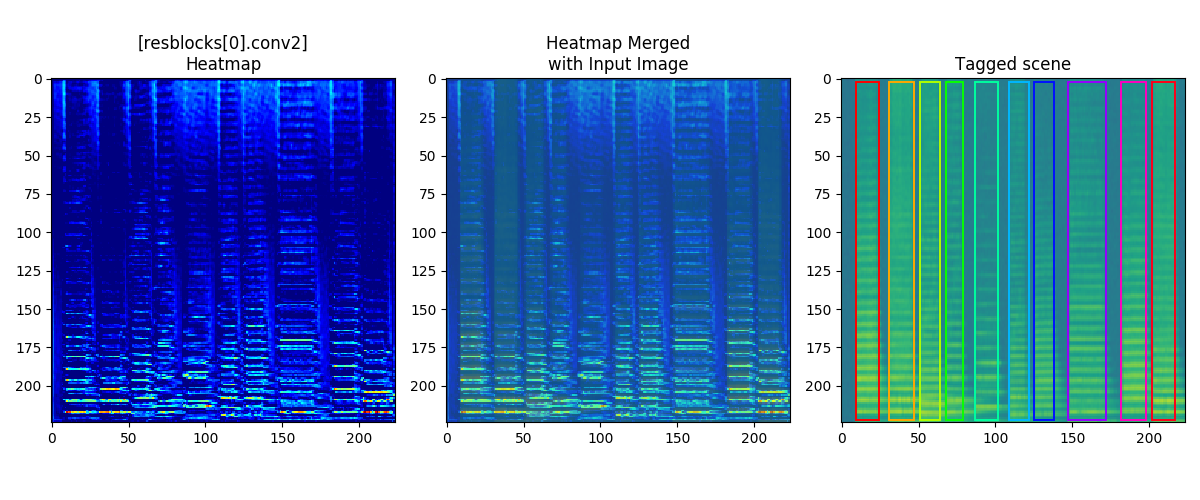

<IPython.core.display.Javascript object>


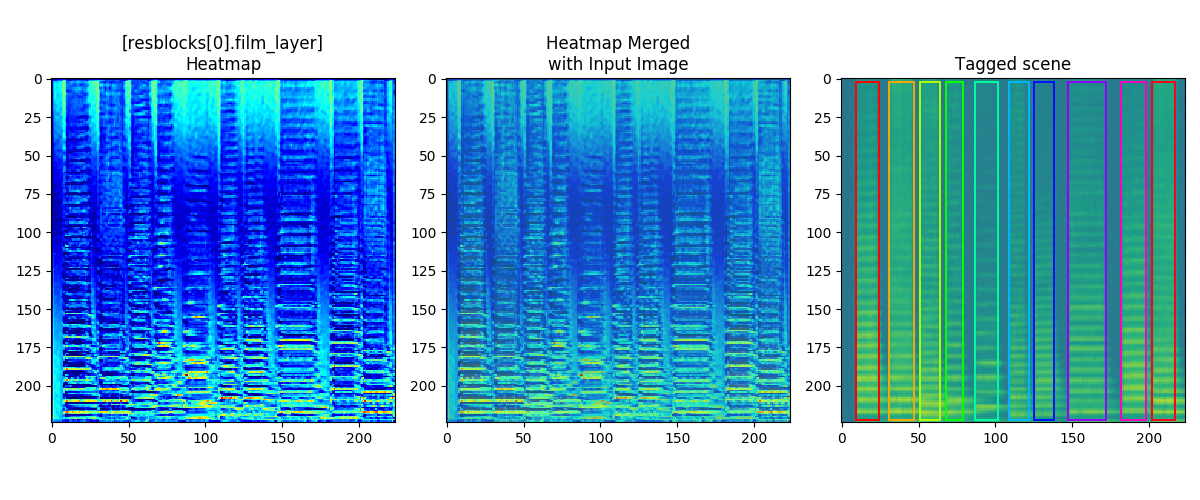

<IPython.core.display.Javascript object>


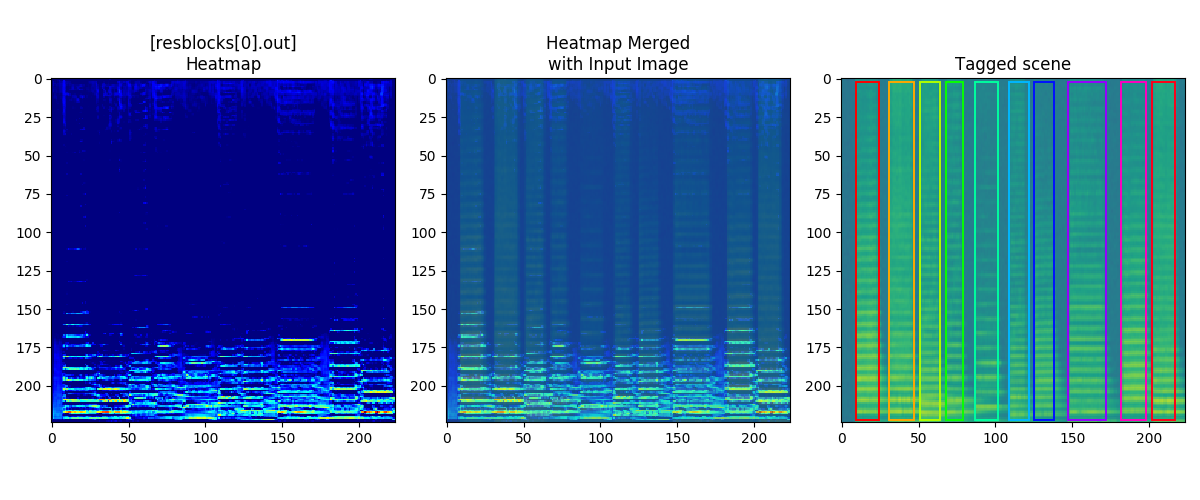

<IPython.core.display.Javascript object>


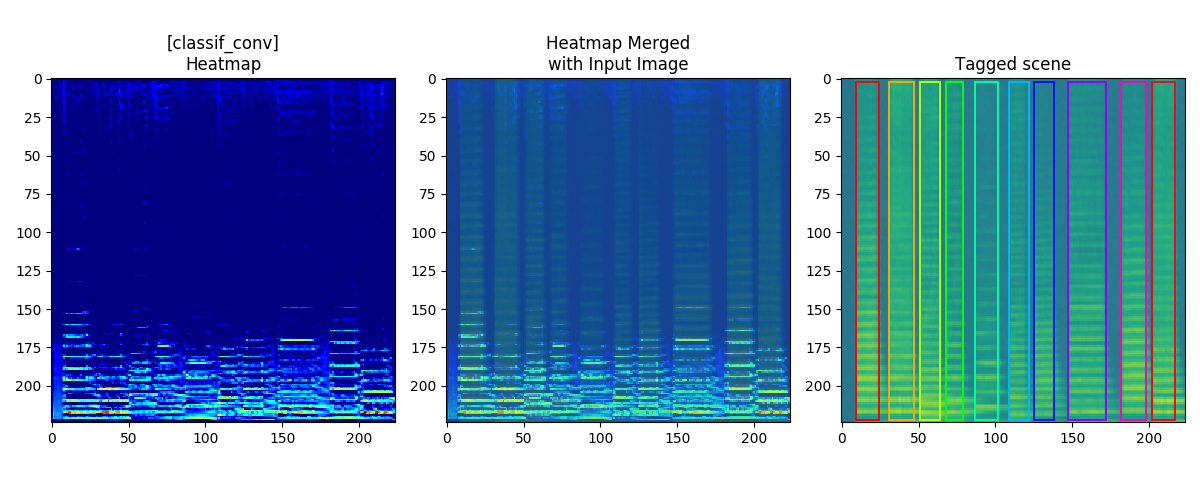

In [5]:
from utils.notebook.inference import do_custom_question_inference, show_gradcam

# MODIFY THIS TO GET GRADCAM FOR DIFFERENT GUESSES
gradcam_guess_id = 0

custom_game, top_preds = do_custom_question_inference(device, film_model, dataloaders[set_type], custom_question, scene_id, nb_top_pred=5)
heatmaps = show_gradcam(device, film_model, dataloaders[set_type], custom_game, scene_id, guess_id=gradcam_guess_id, 
                        top_preds=top_preds, clear_stats=film_model_config['preprocessing']['clear_stats'])

In [6]:
# Activations
